This notebook loads a unfil, unwrapped igram and the DEM and plots phase vs. elevation (2D histogram perhaps?) to see if there is a linear relationship.

This notebook was written on 5-10-23. 

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
%matplotlib  widget

In [2]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
igram_dates = slc_dates[1::]

Load the DEM.

In [3]:
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000
# larger cropped area with western mountains 
dx = 4000
dy = 1100

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)

print('DEM loaded.')

DEM loaded.


Plot the DEM.

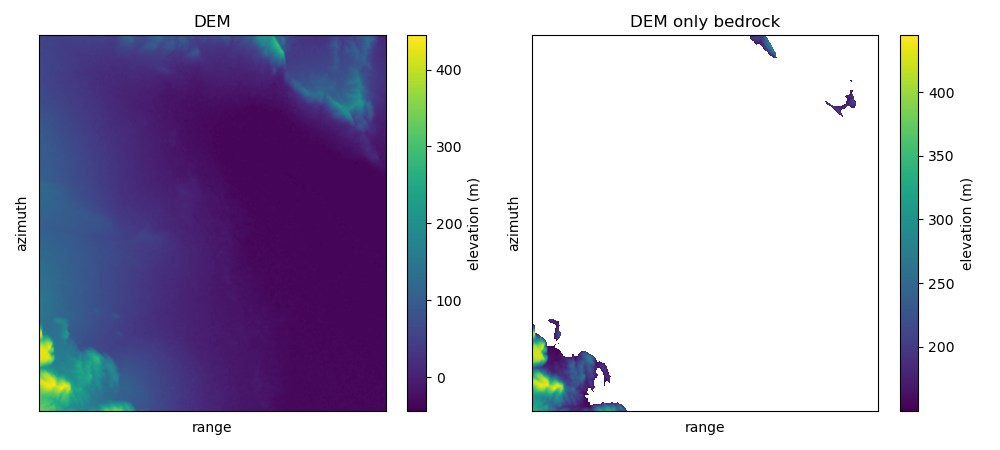

In [4]:
# where does bedrock start? We want to start the line fit to topography where the bedrock starts. 
elev_cutoff = 150
elev_masked = np.ma.masked_where(elev<elev_cutoff,elev)

plt.figure(figsize=(10,4.5),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(elev, cmap='viridis',aspect='auto'); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('DEM'); plt.colorbar(label='elevation (m)')
plt.subplot(1,2,2)
plt.imshow(elev_masked, cmap='viridis',aspect='auto'); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('DEM only bedrock'); plt.colorbar(label='elevation (m)')
plt.show()

Load an unfilt, unwrapped igram and plot it.

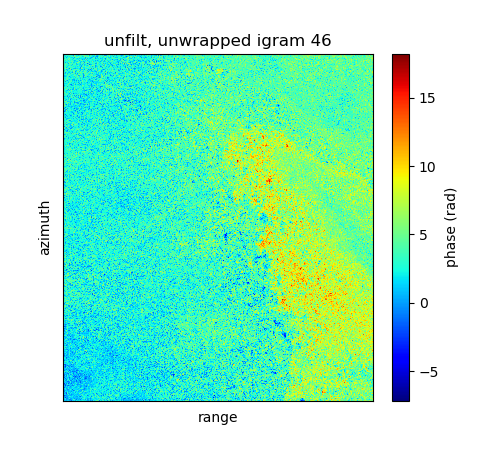

In [5]:
driver=gdal.GetDriverByName('ISCE')

# igramsDir is where the cropped, unwrapped igrams are
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'

i = 46
igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)

# plot it 
plt.figure(figsize=(5,4.5))
plt.imshow(temp_igram, cmap='jet',aspect='auto',interpolation='nearest'); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('unfilt, unwrapped igram '+str(i)) 
plt.colorbar(label='phase (rad)'); plt.show()

Load the ref pix mask.

In [6]:
# load reference pixels mask 
#maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

# filter size for calculating average reference pixels phase value for each igram.
alooks=4*4
rlooks=20*4
# filter it to use for reference pixel phase calculation.
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])

Reference pixel mask loaded.


Now fit a line, see if it fits the data. And plot it as a 3D histogram instead.

In [7]:
import matplotlib.colors as mcolors
numBins = 200
# add condition that elevations over -20 m 
phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
els = elev.flatten()[(elev.flatten() > elev_cutoff)]
m, b = np.polyfit(els,phs,1)
x = [els.min(), els.max()]
y = [m*els.min()+b, m*els.max()+b]

# correcting ALL phases with elevation
min_elev = min(elev.flatten())
temp_igram_cor = temp_igram - (elev-min_elev)*m # + b

print('correction calculated and applied.')

# mask the corrected igram based on ref pix 
temp_igram_corr_masked = np.ndarray((dy,dx),dtype='float')
temp_igram_corr_masked.fill(np.nan)
temp_igram_corr_masked[mask_y,mask_x] = temp_igram_cor[mask_y,mask_x]

# remove the mean value 
igram_masked = np.zeros((dy,dx))
igram_masked[mask_y,mask_x] = temp_igram[mask_y,mask_x]
igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
# ignore the divide-by-zero error messages that pop up in each loop iteration.
np.seterr(divide='ignore', invalid='ignore')
ab = igram_filt / ref_mask_filt
ref_mean = np.nanmean(ab) 

print('mean value calculated and subtracted.')

correction calculated and applied.
mean value calculated and subtracted.


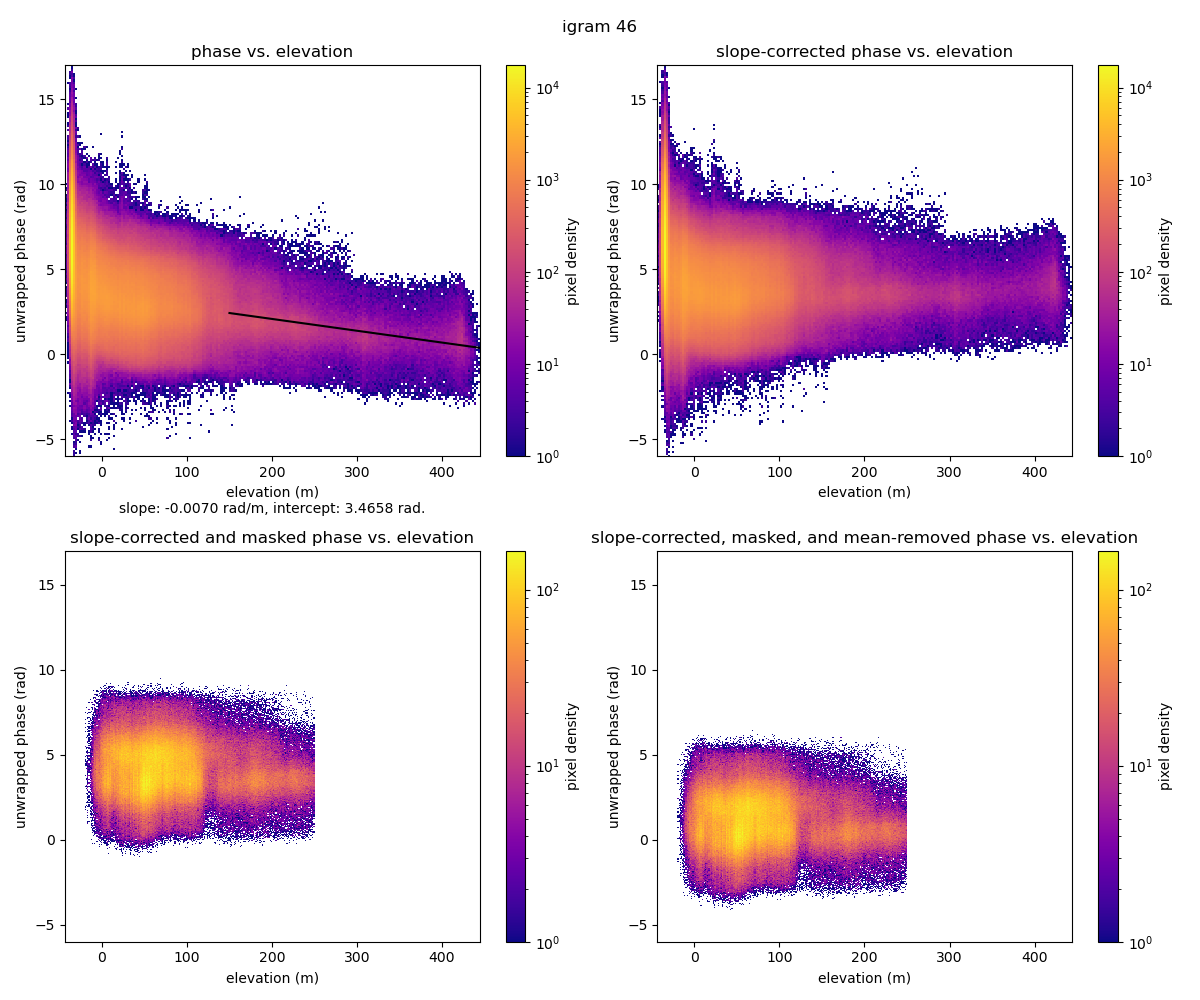

In [8]:
plt.figure(figsize=(12,10),tight_layout=True)
plt.subplot(2,2,1)
plt.hist2d(elev.flatten(),temp_igram.flatten(),bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.plot(x,y,'k-')
plt.ylim([-6,17])
plt.ylabel('unwrapped phase (rad)')
text = 'slope: '+str('%.4f' % m)+' rad/m, intercept: '+str('%.4f' % b)+' rad.'
plt.xlabel('elevation (m)\n'+text)
plt.title('phase vs. elevation') 

plt.subplot(2,2,2)
plt.hist2d(elev.flatten(),temp_igram_cor.flatten(),bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.ylim([-6,17])
plt.ylabel('unwrapped phase (rad)')
plt.xlabel('elevation (m)')
plt.title('slope-corrected phase vs. elevation') 

# mask to just ref pixels 
plt.subplot(2,2,3)
plt.hist2d(elev[mask_y,mask_x].flatten(),temp_igram_cor[mask_y,mask_x].flatten(),bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.ylim([-6,17]); plt.xlim([elev.min(), elev.max()])
plt.ylabel('unwrapped phase (rad)')
plt.xlabel('elevation (m)')
plt.title('slope-corrected and masked phase vs. elevation') 

# mask to just ref pixels AND remove mean value 
plt.subplot(2,2,4)
plt.hist2d(elev[mask_y,mask_x].flatten(),temp_igram_cor[mask_y,mask_x].flatten()-ref_mean,bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.ylim([-6,17]); plt.xlim([elev.min(), elev.max()])
plt.ylabel('unwrapped phase (rad)')
plt.xlabel('elevation (m)')
plt.title('slope-corrected, masked, and mean-removed phase vs. elevation') 

plt.suptitle('igram '+str(i))

plt.show()

Now subtract off the linear relationship just over an elevation threshold. 

[150.00008793592346, 444.49755756785606] [2.4220029139138024, 2.4220029141898327]


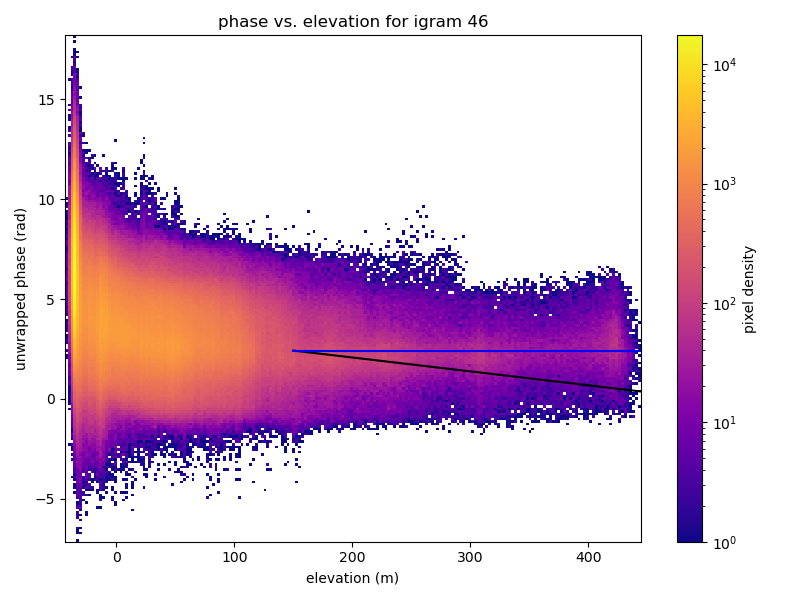

corrected slope: 9.372920766269541e-13 rad/m, corrected intercept: 2.4220029137732086 rad.


In [9]:
numBins = 200
# add condition that elevations over elev_cutoff 
phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
els = elev.flatten()[(elev.flatten() > elev_cutoff)]
m, b = np.polyfit(els,phs,1)
x = [els.min(), els.max()]
y = [m*els.min()+b, m*els.max()+b]

phs_2 = np.copy(temp_igram)
# change the phs where elev is above cutoff 
phs_2[(elev > elev_cutoff)] = phs_2[(elev > elev_cutoff)] - (elev[(elev > elev_cutoff)]-elev_cutoff)*m
phs_3 = phs_2.flatten()[(elev.flatten() > elev_cutoff)]
m_2, b_2 = np.polyfit(els,phs_3,1)
x_2 = [els.min(), els.max()]
y_2 = [m_2*els.min()+b_2, m_2*els.max()+b_2]
print(x_2,y_2)

plt.figure(figsize=(8,6),tight_layout=True)
h = plt.hist2d(elev.flatten(),phs_2.flatten(),bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
#h = plt.hist2d(phs,els,bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.plot(x,y,'k-')
plt.plot(x_2,y_2,'b-')
plt.ylabel('unwrapped phase (rad)'); plt.xlabel('elevation (m)')
plt.title('phase vs. elevation for igram '+str(i)) 
plt.show()

print('corrected slope: '+str(m_2)+' rad/m, corrected intercept: '+str(b_2)+' rad.')

Subtract off the relationship for all pixels. 

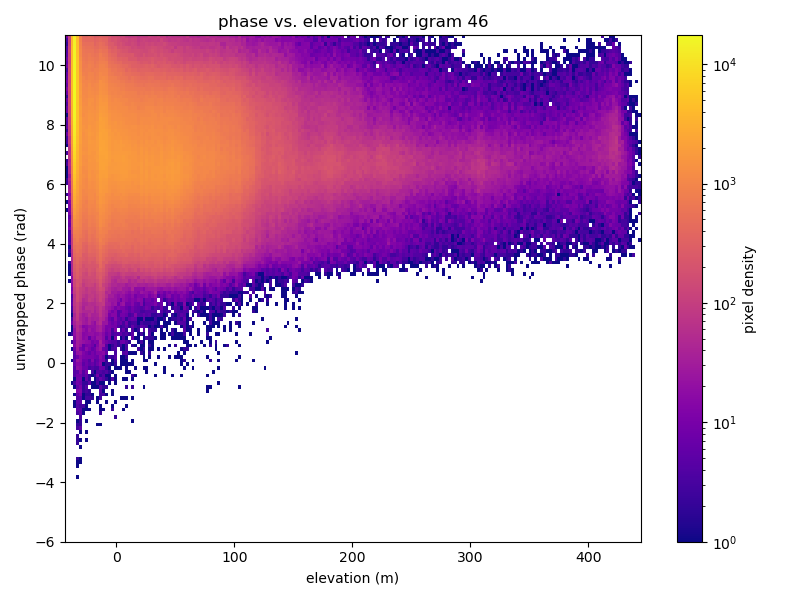

slope: -0.006958493350222264 rad/m, intercept: 3.4657769162445704 rad.


In [10]:
import matplotlib.colors as mcolors
numBins = 200
# add condition that elevations over -20 m 
phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
els = elev.flatten()[(elev.flatten() > elev_cutoff)]
m, b = np.polyfit(els,phs,1)

# correcting ALL phases with elevation
temp_igram_2 = temp_igram - elev*m + b

plt.figure(figsize=(8,6),tight_layout=True)
plt.hist2d(elev.flatten(),temp_igram_2.flatten(),bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.ylim([-6,11])
plt.ylabel('unwrapped phase (rad)'); plt.xlabel('elevation (m)')
plt.title('phase vs. elevation for igram '+str(i)) 
plt.show()

print('slope: '+str(m)+' rad/m, intercept: '+str(b)+' rad.')

Remove the effects of elevation and plot the igram. 

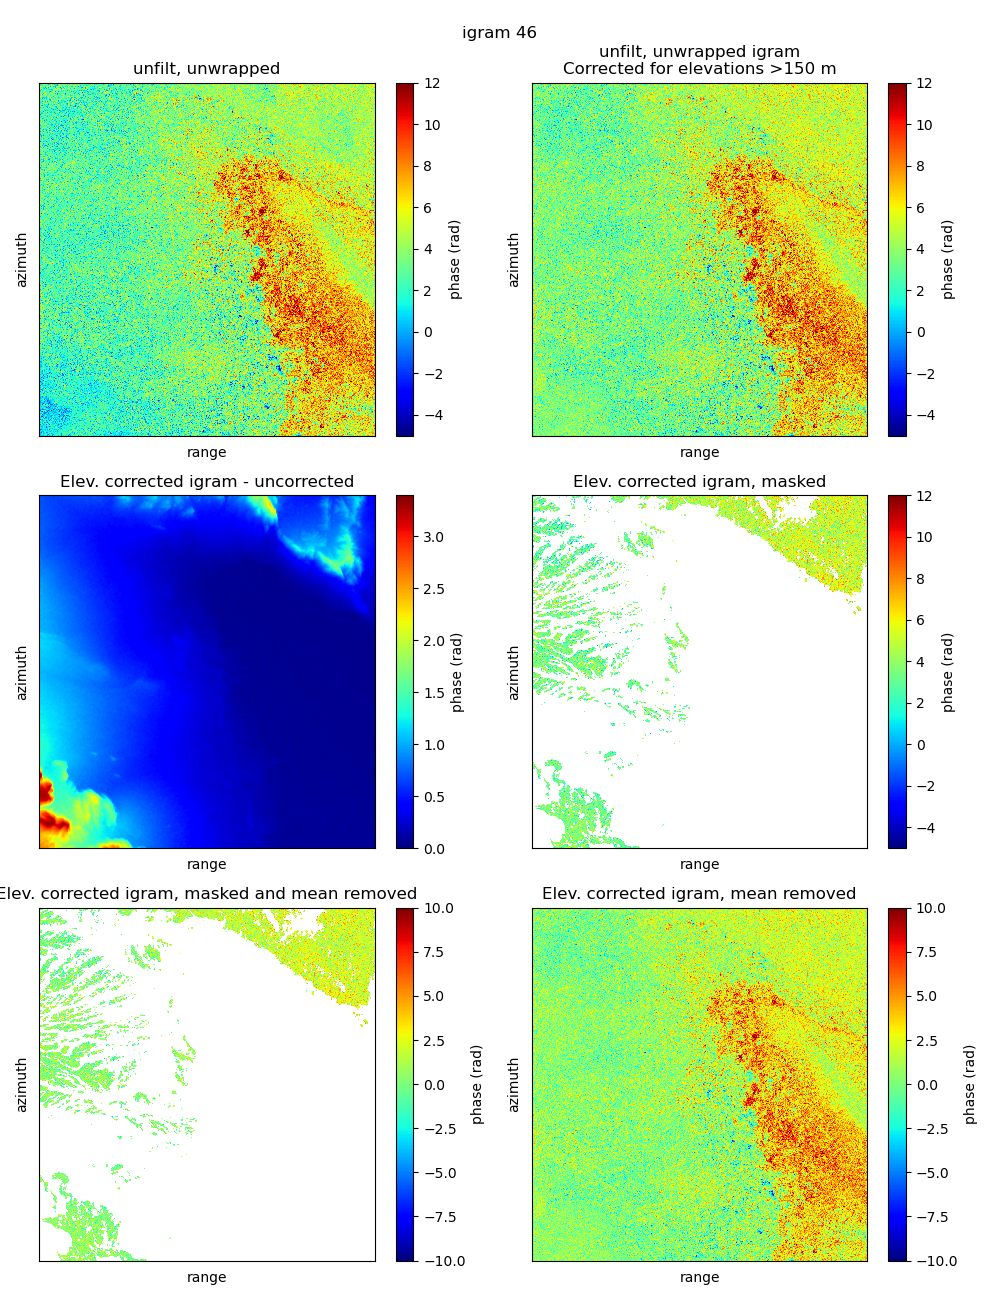

In [11]:
# plot it 
plt.figure(figsize=(10,13),tight_layout=True)
plt.subplot(3,2,1)
plt.imshow(temp_igram, cmap='jet',aspect='auto',interpolation='nearest',vmin=-5,vmax=12); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('unfilt, unwrapped') 
plt.colorbar(label='phase (rad)')

plt.subplot(3,2,2)
plt.imshow(temp_igram_cor, cmap='jet',aspect='auto',interpolation='nearest',vmin=-5,vmax=12); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('unfilt, unwrapped igram\nCorrected for elevations >150 m') 
plt.colorbar(label='phase (rad)') 

plt.subplot(3,2,3)
plt.imshow(temp_igram_cor-temp_igram, cmap='jet',aspect='auto',interpolation='nearest'); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Elev. corrected igram - uncorrected') 
plt.colorbar(label='phase (rad)') 

plt.subplot(3,2,4)
plt.imshow(temp_igram_corr_masked, cmap='jet',aspect='auto',interpolation='nearest',vmin=-5,vmax=12); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Elev. corrected igram, masked') 
plt.colorbar(label='phase (rad)') 

plt.subplot(3,2,5)
plt.imshow(temp_igram_corr_masked-ref_mean, cmap='jet',aspect='auto',interpolation='nearest',vmin=-10,vmax=10); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Elev. corrected igram, masked and mean removed') 
plt.colorbar(label='phase (rad)') 

plt.subplot(3,2,6)
plt.imshow(temp_igram_cor-ref_mean, cmap='jet',aspect='auto',interpolation='nearest',vmin=-10,vmax=10); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Elev. corrected igram, mean removed') 
plt.colorbar(label='phase (rad)') 

plt.suptitle('igram '+str(i))
plt.show()

Calculate slope and intercept for ALL igrams, see how they vary.

In [12]:
slopes = np.ndarray((numIgrams,),dtype='float')
intercepts = np.ndarray((numIgrams,),dtype='float')

for i in range(numIgrams):
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # add condition that elevations over 125 m (relationship applies best for bedrock/high elevations)
    phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
    els = elev.flatten()[(elev.flatten() > elev_cutoff)]
    m, b = np.polyfit(els,phs,1)
    slopes[i] = m
    intercepts[i] = b
    print('slope: '+str(m)+' rad/m, intercept: '+str(b)+' rad.')
print('done.')

slope: 0.012412511721528855 rad/m, intercept: 0.5799043700293112 rad.
slope: -0.0012376437593114478 rad/m, intercept: 5.66822597921316 rad.
slope: 0.003798795139429816 rad/m, intercept: 4.23209307824628 rad.
slope: -6.393251166939287e-05 rad/m, intercept: 4.812916999222586 rad.
slope: -0.02791199179103425 rad/m, intercept: 5.389925756862024 rad.
slope: 0.005120650929677442 rad/m, intercept: -7.321966912220847 rad.
slope: 0.004388923178270574 rad/m, intercept: 8.735166537019616 rad.
slope: 0.021750542782901353 rad/m, intercept: -0.17638258356900288 rad.
slope: -0.010299991506888234 rad/m, intercept: 4.5181482181340735 rad.
slope: -0.015881993257742043 rad/m, intercept: 1.169356385777788 rad.
slope: 0.019133614867265492 rad/m, intercept: 2.512691782324237 rad.
slope: -0.0019991009594179225 rad/m, intercept: 6.937166182054884 rad.
slope: 0.005216626524430915 rad/m, intercept: 6.064106445492688 rad.
slope: -0.004005836803861012 rad/m, intercept: 4.935836879041811 rad.
slope: -0.00228783466

Plot the slopes over time. 

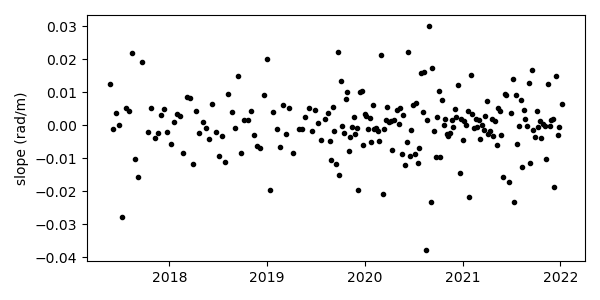

9.834720185194892e-05


In [13]:
plt.figure(figsize=(6,3),tight_layout=True)
plt.plot(igram_dates,slopes,'k.')
plt.ylabel('slope (rad/m)')
plt.show()
print(np.mean(slopes))

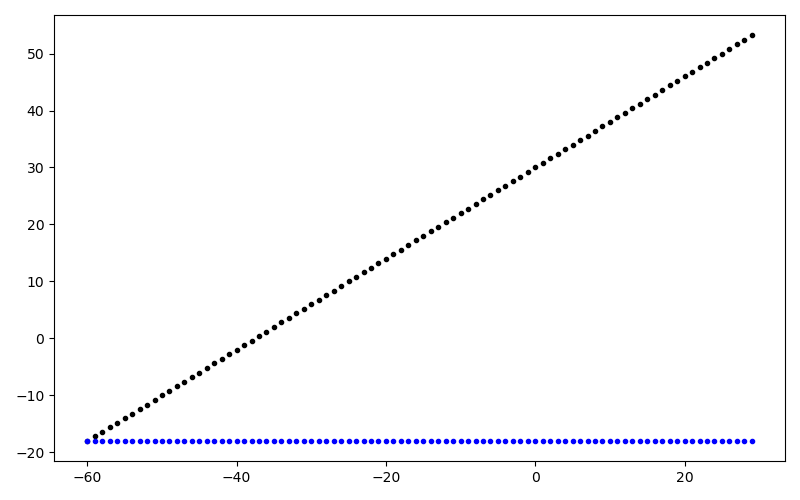

In [14]:
# make a little test dataset 

X = np.arange(-60,30,1)
slope = 0.8
intercept = 30.0
Y = slope*X + intercept
# remove out the slope
Y2 = Y - slope*(X-X.min())

plt.figure(figsize=(8,5),tight_layout=True)
plt.plot(X,Y,'k.')
plt.plot(X,Y2,'b.')
plt.show()